<div style="background-color: #78E8A3; padding: 20px">
<h3>Project Scenario</h3>
<p>Manually annotate the definitions and judge whether the definition is misogynist or otherwise. Misogyny means "dislike of, contempt for, or ingrained prejudice against women.", i.e. any definitions that disparage women.</p>
<p>In this project, we will use the dataset we've annotated to build a machine learning model to classify for misogyny.</p> 
</div>

The dataset that we will work with comes from the hard work of Theodore Lynn and her team, who manually annotated Urban Dictionary definitions. More information can be found in a research publication <a href='https://www.sciencedirect.com/science/article/pii/S2352340919305773'>here</a>.

Download the data <a href = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/3jfwsdkryy-3.zip'>here</a>, or if you can't, do it <a href = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectUrbanDictionaryMisogyny/3jfwsdkryy-3.zip'>here</a> instead.

## Import the Libraries needed

First we import all the libraries required

In [1]:
#!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for wordcloud analysis and cleaning of data
from wordcloud import WordCloud as wc
from wordcloud import STOPWORDS

#libraries for machine learning purposes
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

## Exploring the Data

We start by reading the dataset into a dataframe and looking at the shape (number of rows and columns)

In [3]:
df = pd.read_csv('original-dataset.csv',encoding= 'unicode_escape')

df.head(3)

,Definition,is_misogyny
0,Ur gonna die... queer,0.0
1,Valuptuous man boobs.,0.0
2,Variation of brother.,0.0


In [4]:
print(f'Column Types:\n{df.dtypes}\n')
print(f'Dimensions of dataframe: {df.shape}')

Column Types:
Definition      object
is_misogyny    float64
dtype: object

Dimensions of dataframe: (2286, 2)


### Shape and Dimensions of the Data

As we can see, it is a small set of data, with 2 columns, consisting of an object(string) column and a float column. It appears that the 'Definition' column consist of different phrases eannotated from Urban Dictionary and the column Is_misogyny returns a boolean rating of True or False.

We can confirm that by looking at the value count of the column 'is_misogyny' below. According to the dataset, there are 1251, non-misogynistic phrases and 1034 misogynistic ones

0.0    1251
1.0    1034
Name: is_misogyny, dtype: int64


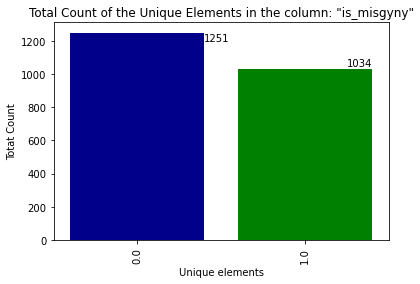

In [5]:
totalcount =df['is_misogyny'].value_counts()

print(totalcount)

totalcount.plot(kind ='bar')
plt.title('Total Count of the Unique Elements in the column: "is_misgyny"')
plt.ylabel('Totat Count')
plt.xlabel('Unique elements')
plt.text(0.40,1200,'1251')
plt.text(1.25,1050,'1034')
plt.bar([0,1],[1251,1034], color=['darkblue', 'green'])

plt.show()

### Missing Values
Next we check for any missing values in the dataset

In [6]:
df.isnull().sum()

Definition     0
is_misogyny    1
dtype: int64

Lets take a look at the missing value and its definition

In [7]:
df_nan = df[df['is_misogyny'].isnull()]
df_nan

,Definition,is_misogyny
1251,When someone makes a post on Facebook and you ...,NaN


Reading the row containing the missing value
Gives us the definition of "double teaming" and does not look liks a misogynistic term

In [8]:
df_nan.iloc[0]['Definition']

"When someone makes a post on Facebook and you and another friend (the double teamers) both comment on the post in order to make fun of the original post. The comments almost always end in smiley faces to express sarcastic joy or happiness. The comments need to be made close together time-wise and should convey a similar message.\n\nThis is often used when a couple are getting too lovey dovey on Facebook and you want to ruin the moment and make it awkward for both of them. It is best to use it when the couple just like each other and aren't going out yet. Use it then for optimum awkwardness. Facebook double teaming is also used to make fun of a dude who is whipped by his girl. [Whit-cheee]\n\nIt can also be used to argue and make fun of people who make stupids posts or statuses."

## Data Cleaning
After a short exloration of the dataset, we shall move on to cleaning it up before performing wordcloud analysis on fitting it into a machine learning model.

### Filling in the missing values
First we'll be replacing the null value(NaN) with 0 as it does not look like a misogynistic phrase. 

In [9]:
df.replace(np.nan,0.0,inplace=True)

df.isnull().sum()

Definition     0
is_misogyny    0
dtype: int64

### Removing punctuations and turning values of the column Definition to lowercase

This is to make it easier to run our analysis and fit the data into the different models.
To do this we'll be creating a new column to store this "cleaned" definition in case there is a need to reference back to the original inputs.

In [10]:
#remove punctuations
df['cleaned_definition'] = df['Definition'].str.replace('[^\w\s]','',regex=True)

#convert to lowercase
df['cleaned_definition']= df['cleaned_definition'].map(lambda x: x.lower())

#check the bottom of the dataframe to verify
df.tail(3)

,Definition,is_misogyny,cleaned_definition
2283,Any vaginal secretion,1.0,any vaginal secretion
2284,Person who slaps hoes,1.0,person who slaps hoes
2285,That hoe out there!!!,1.0,that hoe out there


## Analysing using Wordcloud


First, we have to combined all of the strings in the 'cleaned_definition' column into one huge string. To be able to generate the word cloud. 

In [11]:
cleaned_definition_str = ' '.join(df['cleaned_definition'])

#Take a look at a portion of it
cleaned_definition_str[0:498]

'ur gonna die queer valuptuous man boobs variation of brother very impressive penis what i call my penis what a real man eats what every man fears what i named my dick when a gay guy farts when a man ejaculates when a man jacks off when man gets a boner when two bros frolic when you gay and ugly whip it out a penis who the fuck is that who ate all the pies who cares its fake young bisexual male buttsex rearranged slang for lesbian cum bubble thera penis up the butt short dick syndrome a vampire'

### Building Wordclouds to visualize the dataset
Now that we've created the long string, it's time to build the wordcloud.
A quick disclaimer. While Wordclouds helps us to visualize and understand at a glance, there is no way to get an accurate value for futher disection and words that are longer take up space and may create an illusion of quantity.

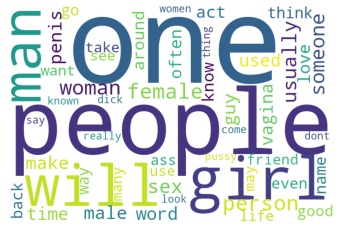

In [13]:
#Create a WordCloud object with a 'white' 'background_color'
#Put the max words to show as 50 to reduce noise
#Call the .generate method of the WordCloud object with the combined column string
#Use plt to visualize the generated wordcloud

wc1 = wc(max_words=50,width=720, height=480, margin=0, background_color= 'white').generate(cleaned_definition_str)
plt.imshow(wc1)
plt.axis('off')
plt.show()

From this we can immediately see the few words that jump out from this dataset. They're: people, one, girl, will, man and perhaps female or person.

### Build two more Wordclouds to see the difference between misogynist and non-misogynist definitions

Let us go one step further in the wordcloud analysis and split the dataframes between those labeled misogynist and non-misogynist to see if we can gather any quick insights from there.

In [14]:
#Split the df into two df based on the value 0 or 1 for misogyny and not so
df_nonmisogynist = df[df['is_misogyny']==0.0]
df_misogynist = df[df['is_misogyny']==1.0]

#combine each definition into a single string as done previously above
nonmisogynist_cleaned_definition_str = ' '.join(df_nonmisogynist['cleaned_definition'])
misogynist_cleaned_dfinition_str = ' '.join(df_misogynist['cleaned_definition'])

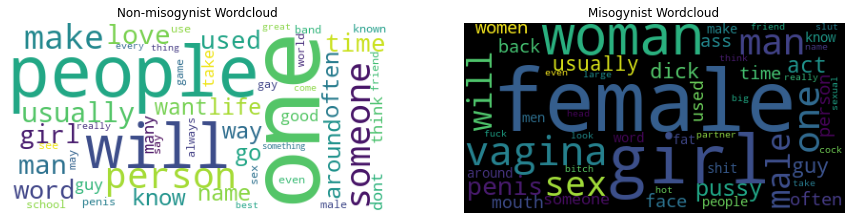

In [15]:
plt.subplots(figsize =(15,10))

#1st wordcloud for non-misogynist
nm_wc = wc(max_words=50, background_color= 'white').generate(nonmisogynist_cleaned_definition_str)
plt.subplot(1,2,1)
plt.imshow(nm_wc)
plt.axis('off')
plt.title('Non-misogynist Wordcloud')

#2nd word cloud for misogynist 
m_wc = wc(max_words =50, background_color ='black').generate(misogynist_cleaned_dfinition_str)
plt.subplot(1,2,2)
plt.imshow(m_wc)
plt.axis('off')
plt.title('Misogynist Wordcloud')

#show both plots at the same time

plt.show()

It can be safetly observed that they both have very different words in the top 3 with the non-misogynist Wordcloud more similiar to the combined one above.
While the Wordcloud generated from those labeled as misogynist, the top 3 are female, girl, and woman or vagina.

## Data Preparation for Machine Learning

After analyzing using Wordcloud, we shall now proceed to prep the dataset particularly the "cleaned_definition" string for machine learning purposes.

We'll first remove stopwords from the string and convert it back into a column. For the definition of stopwords please check out the [wiki](https://en.wikipedia.org/wiki/Stop_word)

Subsequently, using TfidfVectorizer from sklearn we'll vectorize the newly created column and turn it into a binary vector

### Stopwords

In [23]:
#Create a variable for stopwords
stopwords = set(STOPWORDS)

#Take a look at some examples in the set
print('Total number of stopwords',len(stopwords))
print('First 10',list(stopwords)[0:10])

Total number of stopwords 192
First 10 ['than', 'most', 'them', 'myself', "you've", 'also', 'all', 'ever', 'who', 'no']


Create a new column excluding stopwords from cleaned_definition and attaching it to the main dataframe

In [25]:
#Another way of doing it would be: .apply(lambda x: [item for item in x.split() if item not in stopwords])
df['cleaned_definition_nostop'] = df['cleaned_definition'].apply(lambda x: ' '.join(
    [item for item in x.split() if item not in stopwords]))

df.head(3)

,Definition,is_misogyny,cleaned_definition,cleaned_definition_nostop
0,Ur gonna die... queer,0.0,ur gonna die queer,ur gonna die queer
1,Valuptuous man boobs.,0.0,valuptuous man boobs,valuptuous man boobs
2,Variation of brother.,0.0,variation of brother,variation brother


### Using TfidfVectorizer
To prepare our data into a form that will be usable for machine learning, we will turn our text data into a binary vector. 

Term frequency-inverse document frequecy (Tf-idf) is a score that highlights words that are more interesting, i.e. words that occur in a document but not across many documents.

In [26]:
vectorizer = TfidfVectorizer(max_features= 950) #max features was gotten from manually tweaking and testing on the models subsequently.
                                                #this is done to avoid overfitting of the models later
cleaned_definition_vect = vectorizer.fit_transform(df['cleaned_definition_nostop'])
cleaned_definition_vect

<2286x950 sparse matrix of type '<class 'numpy.float64'>'
	with 26787 stored elements in Compressed Sparse Row format>

The result is a sparse matrix where the first 4 digit (2286) is the number of rows and 950 is the number of columns.

### Turn the sparse matrix into a DataFrame
From here we'll turn it back into a dataframe to be used in our model training in the next step. We'll be using csr_matrix from scipy.sparse

In [28]:
df_vect = pd.DataFrame.sparse.from_spmatrix(cleaned_definition_vect)
df_vect.columns = vectorizer.get_feature_names_out()

df_vect.head(3)

,10,12,13,14,20,30,ability,able,absolutely,across,...,worth,written,wrong,year,years,yes,yet,youll,young,youre
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model training

Generally, the machine learning process has five parts:
1. <strong>Split the data into train and test set</strong>
2. <strong>Model creation</strong>
<br>
Import models from sklearn and instantiate them (assign model object to a variable)
3. <strong>model fitting</strong>
<br>
Fit training data into the model and train
4. <strong>model prediction</strong>
<br>
Make a set of predictions using test data
5. <strong>Model assessment</strong>
<br>
Compare predictions with ground truth in test data


### Prepare the independent and dependent variables

In [30]:
X = df_vect
y = df.filter(items = ['is_misogyny'])

### Split the indepedent and dependent variables into train and test sets
We'll be using a 80/20 split for train and test set respectively, using the train_test_split function, stratified by y. 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify = y)

### Train a DummyClassifier model
We'll start with a DummyClassifier which ignore the input features to get the baseline and we're expecting the other models to outperform it.

In [43]:
dclf = DummyClassifier(strategy='stratified')

dclf.fit(X_train,y_train)

y_pred_dclf = dclf.predict(X_test)

In [46]:
#F1 score (weighted average of Precision and Recall)
f1_score(y_test, y_pred_dclf)

0.5060240963855421

In [45]:
#Confusion matrix
con_matrix = confusion_matrix(y_test,y_pred_dclf)
con_matrix

array([[148, 103],
       [102, 105]])

In [47]:
# Accuracy Metric
f'Accuracy: {metrics.accuracy_score(y_test,y_pred_dclf)}'

'Accuracy: 0.5524017467248908'

Our DummyClassifier Model has 

a F1 score (weighted average of Precision and Recall of **50.60%**

an Accuracy of **55.24%**

and a Confusion Matrix as follows:

__|Predicted: False|Predicted:True
---|---|---
Actual: False|148|103
Acutal: True|102|105

Now that we have a baseline model, let's move on to training other models

### LogisticRegression model

In [48]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train.values.ravel())

y_logreg_pred = logreg.predict(X_test)

In [49]:
f'F1 Score: {f1_score(y_test,y_logreg_pred)}'

'F1 Score: 0.8473684210526315'

In [50]:
lrm_con_mat= confusion_matrix(y_test,y_logreg_pred)
lrm_con_mat

array([[239,  12],
       [ 46, 161]])

In [51]:
f'Accuracy: {metrics.accuracy_score(y_test,y_logreg_pred)}'

'Accuracy: 0.8733624454148472'

Our LogisticRegression Model has 

a F1 score (weighted average of Precision and Recall of **84.73%**

an Accuracy of **87.34%**

and a Confusion Matrix as follows:

__|Predicted: False|Predicted:True
---|---|---
Actual: False|239|12
Acutal: True|46|161

This is a pretty good result but we would like to test if we can squeeze a better result out of the other available models

### DecisionClassifier model

In [52]:
tclf = DecisionTreeClassifier()

tclf.fit(X_train,y_train.values.ravel())

y_tclf_pred = tclf.predict(X_test)

In [57]:
f'F1 Score: {f1_score(y_test,y_tclf_pred)}'

'F1 Score: 0.8375286041189932'

In [54]:
tclf_con_mat= confusion_matrix(y_test,y_tclf_pred)
tclf_con_mat

array([[204,  47],
       [ 24, 183]])

In [55]:
f'Accuracy: {metrics.accuracy_score(y_test,y_tclf_pred)}'

'Accuracy: 0.8449781659388647'

Our DecisionClassifier Model has 

a F1 score (weighted average of Precision and Recall of **83.75%**

an Accuracy of **84.50%**

and a Confusion Matrix as follows:

__|Predicted: False|Predicted:True
---|---|---
Actual: False|204|47
Acutal: True|24|183

While the results are pretty impression, it fall short of the Logistic Regression Model. Let us try one last model before making our choice

### RandomForestClassifier model

In [58]:
rclf = RandomForestClassifier()

rclf.fit(X_train,y_train.values.ravel())

y_rclf_pred= rclf.predict(X_test)

In [59]:
f'F1 Score: {f1_score(y_test,y_rclf_pred)}'

'F1 Score: 0.865'

In [60]:
rclf_con_mat= confusion_matrix(y_test,y_rclf_pred)
rclf_con_mat

array([[231,  20],
       [ 34, 173]])

In [61]:
f'Accuracy: {metrics.accuracy_score(y_test,y_rclf_pred)}'

'Accuracy: 0.8820960698689956'

Our RandomForestClassifier Model has 

a F1 score (weighted average of Precision and Recall of **86.50%**

an Accuracy of **88.21%**

and a Confusion Matrix as follows:

__|Predicted: False|Predicted:True
---|---|---
Actual: False|231|20
Acutal: True|34|173

Wow with an accuracy of almost 90%, the RandomForestClassifier model would be the choice for this project.

### Feature importance

With the RandomForestClassifier as the model of our choice, let us take a deeper dive and look at the top features the model uses to make a decision.

In [65]:
#Create a DataFrame containing the sorted feature importances of the RandomTreeClassifier

importances = list(zip(df_vect.columns, rclf.feature_importances_))

#Create DataFrame with above array

df_feature_importance= pd.DataFrame(importances)

#rename column in DataFrame

df_feature_importance.rename(columns ={0:'feature', 1:'importances'}, inplace = True)

# sort DataFrame by importances

df_feature_importance.sort_values(by=['importances'], ascending = False,inplace=True)

df_feature_importance.head(5).style.hide_index()

feature,importances
vagina,0.088365
female,0.079378
pussy,0.057255
woman,0.042098
dick,0.021577


The above dataframe list the top 5 words in level of importances the RandomForestClassifier uses to predict if the string falls under a misogynist statement.